<a href="https://colab.research.google.com/github/handelmanjosh/Pixel-_-Sword_Builder/blob/main/Copy_of_LabAnalysis4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initial library includes and installations
run once - does not require you to edit anything

In [8]:

import json
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from munch import munchify
import scipy.stats
from sklearn import linear_model, datasets



#Function definitions and constants
Run once - does not require you to edit anything

These functions are provided for you - see function definitions and comments for more information on their return values and usage

  1. `loadDataSet(filename)` - loads an individual .json file and checks it for really large jumps in major axis angle, which would indicate a problem with the fits; "unwraps" the angle to eliminate discontinuities, for example when the angle crosses from -2$\pi$ to 0.  
  1. `loadAllDataSets(startdir)` - loads all json files in a directory
  1. `meanOverTime(t,y,deltat)` - breaks data up into chunks about delta t long and calculates the average value of y over each chunk (assumes t is evenly spaced and monotonically increasing)
  1. `rateOfChange (t,y)` - calculates dy/dt (assumes t is monotonically increasing)
  1. `m,b,m_e,b_e = fitLine(x,y)` - least squares fit to $y = (m\pm m_e)x + b\pm b_e$ $m_e$ and $b_e$ are the uncertainties (errors) in the estimates of $m$ and $b$
  1. `m,b,me,be,xi,yi,xo,yo = fitLineRansac(x,y)` - least squares fit to y = m x + b , discarding outliers - in addition to m, b, m_e and b_e, this function returns inlying (xi,yi) and outlying (xo,yo) points : uses [RANSAC](https://https://en.wikipedia.org/wiki/Random_sample_consensus) to find outliers
  1. `m,b,me,be,xi,yi,xo,yo = fitLineHuber(x,y)` - least squares fit to y = m x + b , discarding outliers - in addition to m, b, m_e and b_e, this function returns inlying (xi,yi) and outlying (xo,yo) points : uses [Huber](https://scikit-learn.org/stable/modules/linear_model.html#huber-regression) to find outliers

Here we also define some useful constants:

`deghr` multiply by deghr to convert radians per second to degrees per hour

`omega_foucault` predicted orbit precession (in radians per second) due to earth's rotation, at NYC latitude



In [9]:
gaccel = 9.802

nyc_latitude =40.730610
deghr = np.rad2deg(3600)
omega_foucault = -15*np.sin(np.deg2rad(nyc_latitude))/deghr


#loads one data set (work from one lab group stored in a .json file)
#data can be accessed as either a dictionary or a structure
#ie dataset["fits"] and dataset.fits are the same thing
#setupNumber: number on the wall
#section: 1-4 which section data came from
#thetaWall: angle of a line parallel to the wall
#notes
#filename: name of the json file
#fits: list of fits to individual trials
#   filename: path to data file
#   period: period of the pendulum, inferred from the data
#   length: length of the pendulum (in mm), inferred from the period
#   ##(N,) arrays with orbit parameters##
#     number: crossing number at the start of each orbit (from 0, in steps of 2)
#     time: time at the start of each orbit (from 0, in steps of 1 period)
#     maxjaxis: fit major axis (in mm) of each orbit
#     minaxis: fit minor axis (in mm) of each orbit
#     theta: angle (in radians) of the major axis to the x-axis
#     slope: slope of the voltage vs. time trace (in V/s) at the crossing - not used in this analysis
#   


def loadDataSet(filename):
  file = open(filename,'r')
  results = json.load(file)
  file.close
  dataset = munchify(results) #can be accessed as a structure or a dict
  dataset.filename = filename
  dataset.hasAngleToWall = np.abs(dataset.thetaWall) <= 360 #default 9999 is out of range
  valid = []
  for f in dataset.fits:
    try:
      f.hasAngletoWall = dataset.hasAngleToWall
      f.number = np.array(f.number)
      f.time = np.array(f.time)
      f.majaxis = np.array(f.majaxis)
      f.minaxis = np.array(f.minaxis)
      f.theta = np.unwrap(np.array(f.theta))
      f.thetaRelToWall = f.theta - np.pi/180*dataset.thetaWall
      f.slope = np.array(f.slope)
      f.period = 2*(f.time[-1]-f.time[0])/(f.number[-1]-f.number[0])
      f.length = 1000*gaccel*(f.period/(2*np.pi))**2
      dp = np.diff(np.unwrap(f.theta))
      valid.append((np.abs(dp) < np.pi/4).all()) #extremely large jump from one swing to the next - bad fit
    except:
      valid.append(False)
  bad = np.array(valid) == False
  if (bad.any()):
    print('{}: bad fits found in experiments {}'.format(filename, np.where(bad)[0]))
    dataset.fits = [dataset.fits[i] for i in np.where(valid)[0]]
  return dataset

def loadAllDataSets(startdir):
  files = sorted(glob.glob(startdir + '/*.json'))
  return [loadDataSet(f) for f in files]

#my = meanOverTime (t,y,deltat)
#calculates the mean value of y and dy/dt at approximate intervals of deltat
#   e.g. if deltat is 10, then my[0] is the average value of y between 
#   t[0] and t[0] + 10
#detalt is adjusted downward to evenly divide the whole range
#   e.g. if deltat is 100 and t ranges from 0 to 110 seconds, then delta t will be 55
def meanOverTime (t, y, deltat):
  numpts = int(np.ceil((t[-1]-t[0])/deltat)) + 1
  inds = np.linspace(0,len(t),numpts, endpoint=False, dtype=int)
  dt = np.gradient(t)
  my = np.diff((np.cumsum(y)*dt)[inds])/np.diff(t[inds])
  return my

#dy_dt = rateOfChange(t,y)  
def rateOfChange (t,y):
  return np.gradient(y)/np.gradient(t)


#m,b,m_e,b_e = fitLine(x,y)
#least squares fit to y = m x + b : m_e,b_e are uncertainties in m,b
def fitLine(x,y):
  p = np.polyfit(x,y,1)
  res = y - p[0]*x - p[1]
  m_e = np.sqrt(np.var(res)/(len(x)*np.var(x)))
  b_e = np.sqrt(np.mean(x**2))*m_e
  return (p[0],p[1],m_e,b_e)
  
#m,b,me,be,xi,yi,xo,yo = fitLineHuber(x,y)
#least squares fit to y = m x + b , discarding outliers
#xi,yi are x,y values used (inliers) 
#xo.yo are x,y values discarded (outliers)
def fitLineHuber(x,y,epsilon=2):
  huber = linear_model.HuberRegressor(epsilon=epsilon)
  huber.fit(x.reshape(-1,1),y)
  outlier_mask = huber.outliers_
  inlier_mask = np.logical_not(outlier_mask)
  (m,b,me,be) = fitLine(x[inlier_mask], y[inlier_mask])
  xi = x[inlier_mask]
  yi = y[inlier_mask]
  xo = x[outlier_mask]
  yo = y[outlier_mask]
  return (m,b,me,be,xi,yi,xo,yo)

#m,b,me,be,xi,yi,xo,yo = fitLineRansac(x,y)
#least squares fit to y = m x + b , discarding outliers
#xi,yi are x,y values used (inliers) 
#xo.yo are x,y values discarded (outliers)
def fitLineRansac(x,y):
  #print(np.median(np.abs(y - np.median(y))))
  ransac = linear_model.RANSACRegressor()
  ransac.fit(x.reshape(-1,1),y.reshape(-1,1))
  inlier_mask = ransac.inlier_mask_
  res = y[inlier_mask]-ransac.predict(x.reshape(-1,1))[inlier_mask,0]
  ransac.residual_threshold = np.median(np.abs(res))
  ransac.fit(x.reshape(-1,1),y.reshape(-1,1))

  ransac.stop_probability = 1
  ransac.max_trials = 10000
  ransac.min_samples = 0.1
  res = y[inlier_mask]-ransac.predict(x.reshape(-1,1))[inlier_mask,0]
  ransac.residual_threshold = 2.5*np.std(res)
  ransac.fit(x.reshape(-1,1),y.reshape(-1,1))
  inlier_mask = ransac.inlier_mask_

  outlier_mask = np.logical_not(inlier_mask)
  (m,b,me,be) = fitLine(x[inlier_mask], y[inlier_mask])
  xi = x[inlier_mask]
  yi = y[inlier_mask]
  xo = x[outlier_mask]
  yo = y[outlier_mask]
  #print(ransac.n_trials_)
  return (m,b,me,be,xi,yi,xo,yo)

#Fetch the data to be analyzed
** Change the first github repository name to match your username (lab4-individual-data-yourname)  **
then run once

In [12]:
!rm -rf mydata/
!rm -rf data/
!git clone https://github.com/NYU-IEP-2022-3-Classroom/lab4-data-repository-FluxDecay  mydata #change to your github username
!git clone https://github.com/NYU-IEP-2022-3-Classroom/lab4-shared-data-repository-whole-class data

Cloning into 'mydata'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 52 (delta 6), reused 47 (delta 5), pack-reused 0
Unpacking objects: 100% (52/52), done.
Cloning into 'data'...
remote: Enumerating objects: 181, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 181 (delta 41), reused 100 (delta 39), pack-reused 78
Receiving objects: 100% (181/181), 17.66 MiB | 18.23 MiB/s, done.
Resolving deltas: 100% (57/57), done.


#load the data sets to be analyzed
run once

1. `mydata = loadAllDataSets('/content/mydata/')[0]` - load your data -- the [0] is because you only have one data set, so we'll take it out of the list to look at it alone
1. `alldata = loadAllDataSets('/content/data/')` - load everyone's data - each element of this list is one dataset

When you load the data, you might get a message about bad fits, if someone (not YOU of course) uploaded problematic files to the shared repository. As long as there are only a few of these messages, don't worry about it. 

## fields in dataset structure
- `setupNumber`: number on the wall
- `section`: 1-4 which section data came from
- `thetaWall`: angle of a line parallel to the wall
- `z0`: calibrated magnet height
- `filename`: name of the json file
- `fits`: list of fits to individual trials
   - `anglePath`: path to angle data file
   - `magPath`: path to magnetometer data file
   - `offset`: (x,y) calculated offset of the magnetometer from 0
   - `tiltAngle`: calculated angle the magnet was tilted away from z-axis
   - `L`: calculated length of the string (in mm, derived from period)
   - `B0`: best estimate of magnetic field strength z0 away directly along magnet axis
   - `hasAngleToWall`: whether the original experimenter entered the wall angle
   - the following arrays are all (N,) where N is the number of orbits
    - `number`: crossing number at the start of each orbit (from 0, in steps of 2)
    - `time`: time at the start of each orbit (from 0, in steps of 1 period)
    - `maxjaxis`: fit major axis (in mm) of each orbit
    - `minaxis`: fit minor axis (in mm) of each orbit
    - `theta`: angle (in radians) of the major axis to the x-axis
    - `thetaRelToWall`: angle (in radians) of the major axis rel to an axis aligned with the wall
    - `slope`: slope of the voltage vs. time trace (in V/s) at the crossing - not used in this analysis
  
So to plot the angle vs time for your first experiment:

```plt.plot(mydata.fits[0].time, mydata.fits[0].theta)```


/content/data/section1setup10-21-Nov-2021.json: bad fits found in experiments [3]
/content/data/section1setup10-21-Nov-2022.json: bad fits found in experiments [3]
/content/data/section1setup5-14-Nov-2022.json: bad fits found in experiments [4]
/content/data/section2setup42-22-Nov-2022.json: bad fits found in experiments [0]
/content/data/section2setup5-6-Dec-2022.json: bad fits found in experiments [5 6]


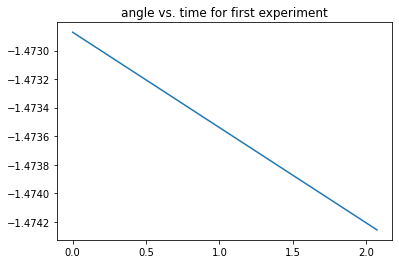

available fields in mydata: 
['setupNumber', 'section', 'thetaWall', 'notes', 'fits', 'filename', 'hasAngleToWall']


In [13]:
mydata = loadAllDataSets('/content/mydata/')[0] 
alldata = loadAllDataSets('/content/data/')

plt.plot(mydata.fits[0].time, mydata.fits[0].theta)
plt.title('angle vs. time for first experiment')
plt.show()

print("available fields in mydata: ")
print(list(mydata.keys()))

#Part 1 - plot the precession rate vs. the predicted precession rate for your experiments

1. Choose a time bin size, $\Delta t$ to average over. Start with `deltat = 60` seconds, but try a few different values once everything works.
1. Create empty lists to store the following results: `predictedrate`, `measuredrate`
1. Loop over each fit (trial) in your set (`for f in mydata.fits:`)
    1. Calculate $\omega = \frac{2\pi}{T}$ Note that the period is stored in `f.period`
    1. Calculate the predicted precession rate (for each orbit, without foucault precession):  $\Omega_{pred} = 0.375 * \omega * \frac{a b}{L^2}$ ($a$ and $b$ (in mm) for each orbit are stored in `f.majaxis` and `f.minaxis` and $L$ (in mm) is stored in f.length). Store the prediction in a variable called `omega_pred`
    1. Calculate the measured precession rate as $\frac{d \theta}{d t}$. Given $t,y$, you can calculate $\frac{dy}{dt}$ using the function `rateOfChange(t,y)`. Note that time and theta are both stored in `f.time` and `f.theta`. Store the measured rate in a variable called `omega_meas`
    1. For both the predicted and measured rates, calculate the means over time, using `meanOverTime` with your stored value of `deltat`
    1. Append the mean-over-time predicted and measured rates to predictedrate and measuredrate. 


1. Convert your lists of fit values to a single array: `pred = np.concatenate(predictedrate)`, `meas = np.concatenate(measuredrate)`
1. Use `plt.scatter` to make a scatter plot of measured (on y-axis) vs. predicted (on x-axis) precession rates. Muiltiply by degrees per hr (`deghr`) before plotting so the axes are reasonable to read. Add  `label = data` as a keywork argument to the plot command.  
1. Plot the prediction of the model and foucault precession: `plt.plot(pred*deghr, (pred + omega_foucault)*deghr, 'm--', label = 'predicted')` as a dashed magenta line
1. Fit the measured rate to the predicted rate (along with the errors in the fit parameters) ($\Omega_{meas} = m*\Omega_{pred} + b$) using `(m,b,me,be) = fitLine(...)` and plot the fit as a black solid line. Make sure to multiply by `deghr`. Add `label = 'm = m+/-me ; b = b+/-be'` (with the results from your fit -- hint use string formatting commands) Multiply b and be in the label by deghr. 
1. Use `plt.legend()` to make a legend
1. Add x and y labels. Here's how I made my x-label `plt.set_xlabel(r'predicted: $\frac{3}{8}\omega \frac{a b}{L^2}$ (deg/hr)')`

1. On a separate plot, make a histogram of the residuals (measured value - fit value) in degrees per hour. Print out the standard deviation of the residuals. 




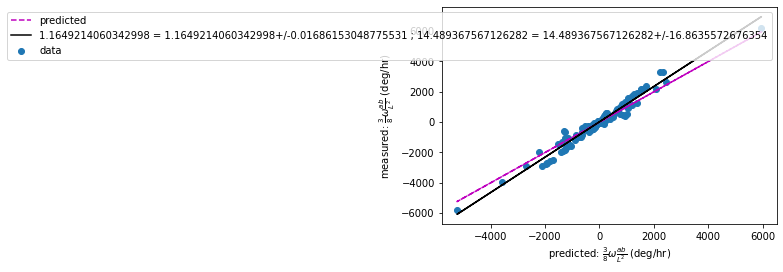

(array([  1.,   0.,   0.,   9.,  25., 138.,  18.,   6.,   1.,   1.]),
 array([-6950.72232039, -5646.48315064, -4342.2439809 , -3038.00481116,
        -1733.76564141,  -429.52647167,   874.71269807,  2178.95186782,
         3483.19103756,  4787.4302073 ,  6091.66937705]),
 <a list of 10 Patch objects>)

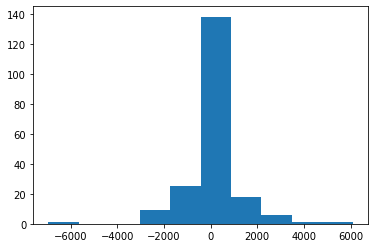

In [29]:
deltat = 10 #seconds
predictedrate: list = []
measuredrate: list = []

for f in mydata.fits:
  omega = 2 * np.pi / f.period
  omega_pred = .375 * omega * (f.majaxis * f.minaxis / (f.length)**2)
  omega_meas = rateOfChange(f.time, f.theta)
  predictedrate.append(meanOverTime(f.time, omega_pred, deltat))
  measuredrate.append(meanOverTime(f.time, omega_meas, deltat))

pred = np.concatenate(predictedrate)
meas = np.concatenate(measuredrate)

plt.scatter(pred *deghr, meas * deghr, label="data")
plt.plot(pred*deghr, (pred + omega_foucault)*deghr, 'm--', label = 'predicted')
(m,b,me,be) = fitLine(pred, meas)
fit = m * (pred * deghr) + (b * deghr)
plt.plot(pred * deghr, fit, color='black', label=f'{m} = {m}+/-{me} ; {b* deghr} = {b * deghr}+/-{be* deghr}')
plt.legend()

plt.xlabel(r'predicted: $\frac{3}{8}\omega \frac{a b}{L^2}$ (deg/hr)')
plt.ylabel(r'measured: $\frac{3}{8}\omega \frac{a b}{L^2}$ (deg/hr)')
plt.show()
plt.clf()
residuals = []

for i, f in enumerate(fit):
  m = meas[i]
  resid = m - f
  residuals.append(resid)

plt.hist(residuals)




#Questions

1. To what extent are your data consistent with the theory? Do you see qualitative agreement (i.e. the direction matches the predicted direction and depends on the size of $ab/L^2$)? Is the measured rate linear in $ab/L^2$ ? Are the slope and intercepts what you would expect?

yes, slope and intercepts are what I would expect: around -9.8 for the intercept and around 1 for the slope. The measured rate is linear and its direction matches the predicted direction.

1. Examining the plots of the data and of the residuals, do you see any evidence of "outliers," measurements that are much farther from the best fit line than you would expect given the other measurements?

Yes, there are 4 outliers

1. If you didn't already, play with `deltat` (try 10, 100 and 300 - don't go below 3 seconds or you might see an error if a time interval has no crossings) and examine how the graph and the fit change. Note any observations below:

The fit gets worse, the outliers disappear



  

#Everyone's data
Now let's apply the same procedure to look at the whole class data set. You should be able to basically reuse your code above. Just wrap the part where you analyze the fits into two loops

```python
ratepred = []
ratemeas = []
deltat = 60
for data in alldata:
  for f in data.fits:
    ....
    ....
pred = np.concatenate(predictedrate)
meas = np.concatenate(measuredrate)
....
....
```

At the end, you should produce the same two plots for everyone's data as you did for your own data

Text(0, 0.5, 'measured: $\\frac{3}{8}\\omega \\frac{a b}{L^2}$ (deg/hr)')

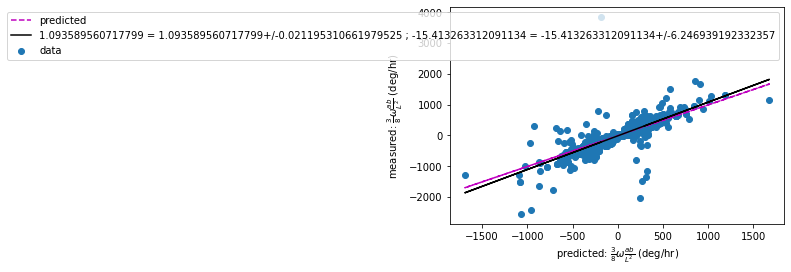

In [27]:
deltat = 60 #seconds
predictedrate: list = []
measuredrate: list = []

for data in alldata:
  for f in data.fits:
    omega = 2 * np.pi / f.period
    omega_pred = .375 * omega * (f.majaxis * f.minaxis / (f.length)**2)
    omega_meas = rateOfChange(f.time, f.theta)
    predictedrate.append(meanOverTime(f.time, omega_pred, deltat))
    measuredrate.append(meanOverTime(f.time, omega_meas, deltat))

pred = np.concatenate(predictedrate)
meas = np.concatenate(measuredrate)

plt.scatter(pred *deghr, meas * deghr, label="data")
plt.plot(pred*deghr, (pred + omega_foucault)*deghr, 'm--', label = 'predicted')
(m,b,me,be) = fitLine(pred, meas)
plt.plot(pred * deghr, m * (pred * deghr) + (b * deghr), color='black', label=f'{m} = {m}+/-{me} ; {b* deghr} = {b * deghr}+/-{be* deghr}')
plt.legend()
plt.xlabel(r'predicted: $\frac{3}{8}\omega \frac{a b}{L^2}$ (deg/hr)')
plt.ylabel(r'measured: $\frac{3}{8}\omega \frac{a b}{L^2}$ (deg/hr)')

#Deal with possible outliers

If you look at the class data, you might see the line is being "pulled up" (or "pulled down") by some measurements with very large predicted and measured rates.

1. One way to deal with this would be to focus only on a smaller range. IE analyze the data where the predicted rate is between -200 and 200 deg/hr. 
1. There are also robust fitting strategies you can use. I've written function `fitLineRansac` and `fitLineHuber` that use these to identify "outliers" - data you discard as unlikely to be correctly measured/part of the same data set. 

Please...

1. Plot all the data as a scatter plot overlaid with the linear fit in black and the prediction as a dashed magenta line (slope = 1, intercept = -9.8 deg/hr). Add the appropriate legend (data, predicted, m = m+/- m_e, b = b+/- b_e). This just duplicates your previous answer. 
1. Make a second figure. Divide the data by whether the absolute value of the predicted rate is more or less than 200 deg/hr. Plot the "inliers" (abs < 200) in blue and the "outliers" in red. Overlay this figure with the linear fit to only the inliers. Add the appropriate legend (data, predicted, m = m+/- m_e, b = b+/- b_e).
1. Make a third figure. Use the `fitLineHuber` function to estimate the model parameters and identify inliers and outliers. As before, plot the inliers in blue, the outliers in red, and overlay the figure with the linear fit to only the inliers. Add the appropriate legend (data, predicted, m = m+/- m_e, b = b+/- b_e).
1. Make a fourth figure that's the same as the third, except use the `fitLineRanac` function. Add the appropriate legend (data, predicted, m = m+/- m_e, b = b+/- b_e).




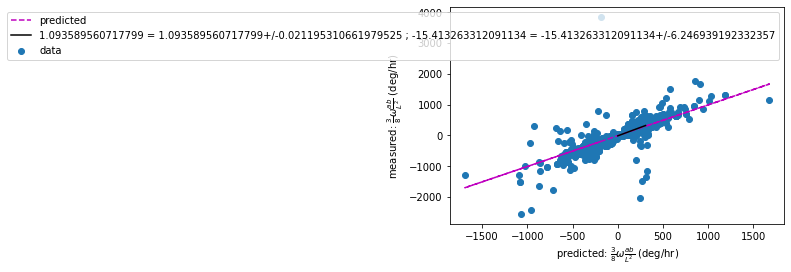

Text(0, 0.5, 'measured: $\\frac{3}{8}\\omega \\frac{a b}{L^2}$ (deg/hr)')

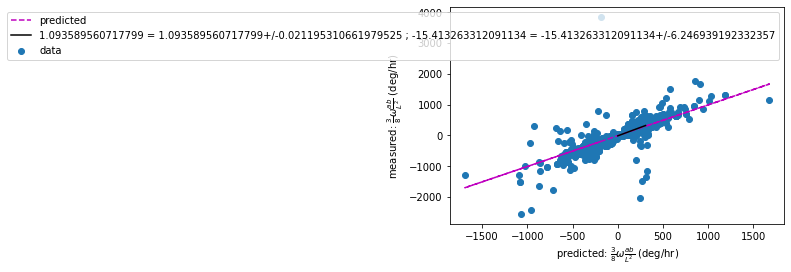

#Questions

1. To what extent are your data consistent with the theory? Do you see qualitative agreement (i.e. the direction matches the predicted direction and depends on the size of $ab/L^2$)? Is the measured rate linear in $ab/L^2$ ? Are the slope and intercepts what you would expect?

1. Do the outliers identified by the algorithms make sense to you? The fitLineHuber takes an optional argument (epsilon=...) that sets how strictly outliers are excluded. I've set the default to 2. Try 1.35 (the toolkit default). Are most of the excluded data truly outliers? If your goal is to make an accurate estimate of the slope, what are the tradeoffs of excluding more outlying data?

1. If your analysis agrees with mine, and if the results hold up over the final week of data collection, it seems like the slope ends up being not exactly 1. Do you think this difference can be explained by random errors? Look both at the error reported by FitLine and at the overall trend in the data. 


#Check on one possible signature of a systematic error

One thing we might consider is whether the pipes on the wall or some other feature of the room is causing an error in either the movement of the bob or our measurement of the orbit. 

As a start, let's sort the data into orbits that are parallel or perpendicular to the wall. We can (very roughly) split the data into two groups based on whether


abs(cos$(\theta-\theta_{wall})) > 1/\sqrt{2}$ (parallel)

or

abs(cos$(\theta-\theta_{wall})) < 1/\sqrt{2}$ (perpendicular)

The fit structure includes data to help you out

- `hasAngleToWall`: (True/False) whether the original experimenter entered the wall angle

- `thetaRelToWall`: angle (in radians) of the major axis rel to an axis aligned with the wall shape: (N,)

So now, please repeat your previous analyses separately for orbits parallel and perpendicular to the wall. I'll put all the steps below, with the new parts highlighted


1. Choose a time bin size, $\Delta t$ to average over. Start with `deltat = 60` seconds, but try a few different values once everything works.
1. **CHANGED** Create empty lists to store the following results: `predictedrate_parallel`, `measuredrate_parallel`,`predictedrate_perpendicular`, `measuredrate_perpendicular` 
1. Loop over all data sets (`for data in alldata:`)
  1. Loop over each fit (trial) in your set (`for f in data.fits:`)
    1. Calculate $\omega = \frac{2\pi}{T}$ Note that the period is stored in `f.period`
    1. Calculate the predicted precession rate (for each orbit, without foucault precession):  $\Omega_{pred} = 0.375 * \omega * \frac{a b}{L^2}$ ($a$ and $b$ (in mm) for each orbit are stored in `f.majaxis` and `f.minaxis` and $L$ (in mm) is stored in f.length). Store the prediction in a variable called `omega_pred`
    1. Calculate the measured precession rate as $\frac{d \theta}{d t}$. Given $t,y$, you can calculate $\frac{dy}{dt}$ using the function `rateOfChange(t,y)`. Note that time and theta are both stored in `f.time` and `f.theta`. Store the measured rate in a variable called `omega_meas`
    1. For both the predicted and measured rates, calculate the means over time, using `meanOverTime` with your stored value of `deltat`. Store these in `mot_pred` and `mot_meas`
    1. **NEW** Calculate the average of `np.cos(f.thetaRelToWall)` over time, using `meanOverTime` with your stored value of `deltat`. Store this in `mot_thetaToWall`
    1. **NEW** define a new variable `parallel = np.logical_and(f.hasAngleToWall,np.abs(mot_thetaToWall) > 1/np.sqrt(2))`
    1. **NEW** define a new variable `perpendicular` that is true if `f.hasAngletoWall` is true and $ |\cos(\theta-\theta_{wall})| < 1/\sqrt{2}$. Hint: this is NOT just `np.logical_not(parallel)`. 
    1. **CHANGED** Append `mot_pred[parallel]` to `predictedrate_parallel`, `mot_meas[parallel]` to `measuredrate_parallel` and so on. 

1. **CHANGED** Convert your lists of fit values to a single array: `pred_parallel = np.concatenate(predictedrate_parallel)`, `meas_perpendicular = np.concatenate(measuredrate_perpendicular)` and so on

1. **CHANGED** Do the following separately for the parallel and perpendicular data sets your created.
  1. Use `plt.scatter` to make a scatter plot of measured (on y-axis) vs. predicted (on x-axis) precession rates. Multiply by degrees per hr (`deghr`) before plotting so the axes are reasonable to read. Add  `label = data` as a keywork argument to the plot command.  
  1. Plot the prediction of the model and foucault precession: `plt.plot(pred*deghr, (pred + omega_foucault)*deghr, 'm--', label = 'predicted')` as a dashed magenta line
  1. Fit the measured rate to the predicted rate ($\Omega_{meas} = m*\Omega_{pred} + b$) using `np.polyfit` and plot the fit as a black solid line. Make sure to multiply by `deghr`. Add `label = 'measured'` to the command. 
  1. Use `plt.legend()` to make a legend
  1. Add x and y labels. Here's how I made my x-label `plt.set_xlabel(r'predicted: $\frac{3}{8}\omega \frac{a b}{L^2}$ (deg/hr)')`
  1. **NEW** Title the plot `parallel to wall` or `perpendicular to wall`
  1. Print out the following information: **parallel or perpendicular:**,  slope of the linear fit between predicted (x) and measured (y) values (would be 1 if measured rates exactly match predicted rates); 2 intercept of the linear fit, multiplied by deghr (would be -9.8 deg/hr if only perturbing influence is foucault precession)


In [ ]:
#your code here